# Classificação de empréstimo padrão

Este celúla mostra meu trabalho de construção de um modelo de classificação binária de linha de base usando Random Forest para prever se haverá um default no empréstimo (status de 'B' ou 'D').
site: https://www.kaggle.com/python10pm/sklearn-50-best-tips-and-tricks 

## Tabela de conteúdo

1. [Conectar ao banco de dados MySQL](#mysql)
2. Análise Exploratória de Dados (Via notebook)
3. [Extração de recurso](#feature_extraction)
4. [Correlação](#correlation)
5. [Transformação](#transformation)
6. [Modelagem](#modeling)
7. [Importância do recurso](#feature_importance)
8. [Direções futuras](#future)

In [1]:
# Importando as Bibliotecas necessárias

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a name='mysql'></a>
## 1. Conectando com Database MySQL 

In [5]:
class MysqlIO:
    """Connect to MySQL server with python and excecute SQL commands."""
    def __init__(self, database='db_banco_emprestimo'):
        try:
            # Alterar o host, usuário e senha conforme necessário
            connection = mysql.connector.connect(host='localhost',
                                                 database=database,
                                                 user='root',
                                                 password='admjairo63',
                                                 use_pure=True
                                                 )
            if connection.is_connected():
                db_info = connection.get_server_info()
                print("Connected to MySQL Server version", db_info)
                print("Your're connected to database:", database)
                self.connection = connection
        except Exception as e:
            print("Error while connecting to MySQL", e)
            
    def execute(self, query, header=False):
        """Execute SQL commands and return retrieved queries."""
        cursor = self.connection.cursor(buffered=True)
        cursor.execute(query)
        try:
            record = cursor.fetchall()
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:    
                return record
        except:
            pass
        
    def to_df(self, query):
        """Return the retrieved SQL queries into pandas dataframe."""
        res = self.execute(query, header=True)
        df = pd.DataFrame(res['record'])
        df.columns = res['header']
        return df

In [6]:
db = MysqlIO('db_banco_emprestimo')

Connected to MySQL Server version 8.0.22
Your're connected to database: db_banco_emprestimo


<a name='feature_extraction'></a>
## 3. Extrair dados


O EDA é feito no notebook 'EDA.ipynb', então de acordo com os dados, vou pegar alguns desses dados e colocá-los em um dataframe e preparar para o ML

### Do Valor empréstimo, conta, distrito

In [9]:
query = """
    select account_id, tb_emprestimo.date date_loan, amount, duration, payments, status, frequency, tb_conta.date date_acc,
        A4, A11, A12, A13, A14, A15, A16
    from tb_emprestimo join tb_conta using(account_id)
    join tb_distrito using(district_id)"""
df = db.to_df(query)

In [10]:
#Verificando o tipo de dado de cada coluna
df.head() 

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,A12,A13,A14,A15,A16
0,1787,1993-07-05,96396,12,8033.00,B,POPLATEK TYDNE,1993-03-22,94812,9650,3.38,3.67,100,2985,2804
1,1801,1993-07-11,165960,36,4610.00,A,POPLATEK MESICNE,1993-02-13,112709,8369,1.79,2.31,117,2854,2618
2,9188,1993-07-28,127080,60,2118.00,A,POPLATEK MESICNE,1993-02-08,77917,8390,2.28,2.89,132,2080,2122
3,1843,1993-08-03,105804,36,2939.00,A,POPLATEK MESICNE,1993-01-30,107870,8754,3.83,4.31,137,3804,3868
4,11013,1993-09-06,274740,60,4579.00,A,POPLATEK TYDNE,1993-02-14,1204953,12541,0.29,0.43,167,85677,99107


In [11]:
df.set_index('account_id', inplace=True)

In [12]:
df['date_loan'] = pd.to_datetime(df.date_loan, format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc, format='%Y-%m-%d')
df['days_between'] = (df['date_loan'] - df['date_acc']).dt.days
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15', 'A16']].mean(axis=1) / df['n_inhabitants']
df['default'] = (df['status'] == 'B') | (df['status'] == 'D')

In [9]:
df.head()

,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,A12,...,A14,A15,A16,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,default
account_id,,,,,,,,,,,,,,,,,,,,,
1787,1993-07-05,96396,12,8033.00,B,POPLATEK TYDNE,1993-03-22,94812,9650,3.38,...,100,2985,2804,105,94812,9650,3.525,100,0.030529,True
1801,1993-07-11,165960,36,4610.00,A,POPLATEK MESICNE,1993-02-13,112709,8369,1.79,...,117,2854,2618,148,112709,8369,2.050,117,0.024275,False
9188,1993-07-28,127080,60,2118.00,A,POPLATEK MESICNE,1993-02-08,77917,8390,2.28,...,132,2080,2122,170,77917,8390,2.585,132,0.026965,False
1843,1993-08-03,105804,36,2939.00,A,POPLATEK MESICNE,1993-01-30,107870,8754,3.83,...,137,3804,3868,185,107870,8754,4.070,137,0.035561,False
11013,1993-09-06,274740,60,4579.00,A,POPLATEK TYDNE,1993-02-14,1204953,12541,0.29,...,167,85677,99107,204,1204953,12541,0.360,167,0.076677,False


### Da ordem

In [10]:
query = """
    select account_id, amount order_amount
    from `t_ordem`
    where account_id in (
        select account_id
        from t_emprestimo);
    """
df_order = db.to_df(query)

In [11]:
df_order.head()

,account_id,order_amount
0,2,3372.70
1,2,7266.00
2,19,2523.20
3,25,2523.20
4,25,6817.00


In [12]:
#Verificando o tipo de dado de cada coluna
#df_order.dtypes 

In [13]:
df_order['order_amount'] = df_order.order_amount.astype('float')
df = df.join(df_order.groupby('account_id').mean())
df = df.rename(columns={'order_amount': 'average_order_amount'})

### Da Transação

In [14]:
query = """
    select account_id, amount trans_amount, balance trans_balance
    from t_transacao
    where account_id in (
        select account_id
        from t_emprestimo);
    """
df_trans = db.to_df(query)

In [15]:
#df_trans.head()

In [16]:
n_trans = df_trans.groupby('account_id').count().iloc[:, 1]
n_trans.name = 'n_trans'

In [17]:
df_trans = df_trans.groupby('account_id').mean()
df_trans.columns = ['average_trans_amount', 'average_trans_balance']

In [18]:
df = df.join(df_trans).join(n_trans, how='left', lsuffix='_left', rsuffix='_right')

### Do Cartão

In [19]:
query = """
    select account_id, t_cartao.type as card_type
    from t_emprestimo join t_disponivel using(account_id)
    left join t_cartao using(disp_id)
    where t_disponivel.type = 'OWNER';
    """
df_card = db.to_df(query)

In [20]:
df = df.join(df_card.set_index('account_id'), how='left')
df['card_type'].fillna('No', inplace=True)

### Do Proprietario

In [21]:
query = """
    select account_id, t_emprestimo.date loan_date, t_conta.district_id acc_dist_id, 
    t_cliente.district_id cli_dist_id, gender owner_gender, birth_date
    from t_emprestimo join t_conta using(account_id)
    join t_disponivel using(account_id)
    join t_cliente using(client_id)
    where t_disponivel.type = 'OWNER';
    """
df_cli = db.to_df(query)

In [22]:
df_cli['same_district'] = df_cli['acc_dist_id'] == df_cli['cli_dist_id']
df_cli['date'] = pd.to_datetime(df_cli['loan_date'], format='%Y-%m-%d')
df_cli['birth_date'] = pd.to_datetime(df_cli['birth_date'], format='%Y-%m-%d')
df_cli['owner_age'] = (df_cli['date'] - df_cli['birth_date']).dt.days // 365

In [23]:
df = df.join(df_cli.set_index('account_id')[['same_district', 'owner_gender', 'owner_age']])

### A lista final de resultados

In [24]:
df_ml = df[['amount', 'duration', 'payments', 'days_between', 'n_inhabitants', 
            'average_salary', 'average_unemployment_rate', 'entrepreneur_rate', 
            'average_crime_rate', 'average_order_amount', 'average_trans_amount',
            'average_trans_balance', 'n_trans', 'owner_age', 
            'frequency', 'card_type', 'same_district', 'owner_gender', 'default']]

In [25]:
df_ml.sample(10)

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,average_order_amount,average_trans_amount,average_trans_balance,n_trans,owner_age,frequency,card_type,same_district,owner_gender,default
account_id,,,,,,,,,,,,,,,,,,,
4033,84288,48,1756.00,121,161954,8720,4.115,116,0.022784,2019.333333,3884.766467,33258.137725,167,19,POPLATEK MESICNE,No,True,female,False
7045,288720,48,6015.00,172,121947,8541,2.740,131,0.030075,6015.300000,12969.105634,62931.295775,142,54,POPLATEK MESICNE,classic,True,male,False
1375,45336,24,1889.00,489,51428,8402,3.555,120,0.020397,3909.500000,6783.614525,51307.854749,358,38,POPLATEK MESICNE,No,True,male,False
10436,54396,36,1511.00,191,110643,8441,3.965,115,0.018668,1511.000000,2794.317460,59367.746032,189,57,POPLATEK MESICNE,No,True,male,False
1819,143676,36,3991.00,447,157042,8743,2.155,111,0.024048,3611.450000,8572.021739,51082.570652,184,45,POPLATEK TYDNE,No,True,male,False
7857,68112,12,5676.00,532,138032,8819,5.520,99,0.031036,3753.000000,9235.305699,53222.272884,579,17,POPLATEK MESICNE,No,False,female,False
2000,290820,60,4847.00,342,95616,9307,4.140,118,0.029577,2056.750000,5134.054688,48864.585938,128,60,POPLATEK MESICNE,classic,True,male,False
3112,123216,48,2567.00,561,85852,8965,7.655,104,0.031886,1873.100000,10987.015945,73384.100228,439,18,POPLATEK MESICNE,junior,True,female,False
6158,247920,48,5165.00,271,106054,8110,6.160,109,0.029810,5165.200000,9098.630631,48419.522523,111,39,POPLATEK MESICNE,No,True,female,True


<a name='correlation'></a>
# 4. Correlações


# Verificação rápida da correlação entre variáveis contínuas.

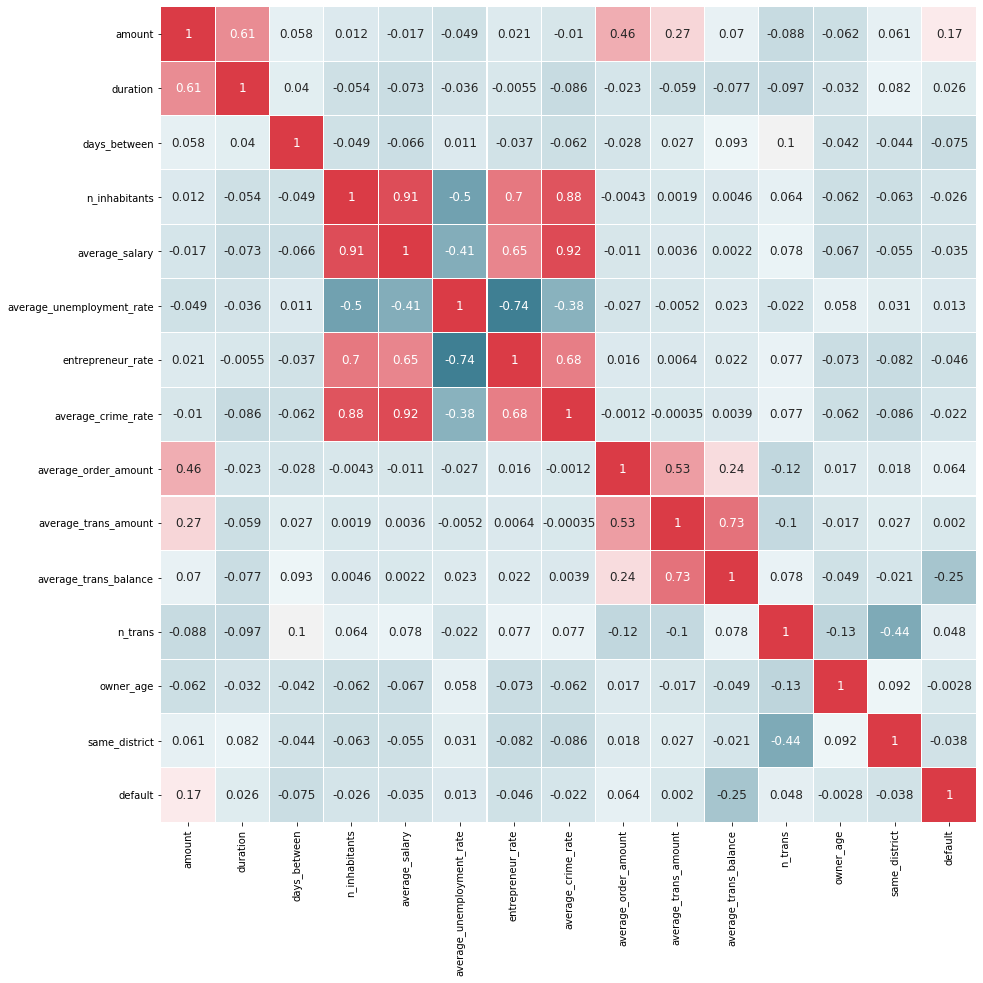

In [26]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
        df_ml.corr(), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar=False,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.show()

<a name='transformation'></a>
## 5. Transformações

Transformações rápidas: as variáveis ​​numéricas são escaladas usando MinMaxScaler e as variáveis ​​categóricas são codificadas em um ponto.

In [56]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [57]:
num_cols = df_ml.columns[:-5]
cat_cols = df_ml.columns[-5:]

In [58]:
col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop="if_binary"), cat_cols)
])

In [59]:
#print(col_trans)

In [60]:
df_transformed = col_trans.fit_transform(df_ml)
X = df_transformed[:, :-1]
y = df_transformed[:, -1]

ValueError: Wrong input for parameter `drop`. Expected 'first', None or array of objects, got <class 'str'>

<a name='modeling'></a>
## 6. Modelagem

Novamente, este é apenas um modelo de linha de base, usando RandomForestClassifier, que é um dos modelos mais populares e simples. As métricas de desempenho são escolhidas de acordo com a precisão, F1, ROC AUC. Além disso, as matrizes de confusão são calculadas.

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [33]:
# Divisão de teste de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

NameError: name 'X' is not defined

In [97]:
# See the inital model performance
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

NameError: name 'X_train' is not defined

### Fine tune

Finetuned using F1 Score.

In [42]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [43]:
clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='f1')
clf.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [44]:
print(clf.best_params_)

NameError: name 'clf' is not defined

In [45]:
clf.best_score_

NameError: name 'clf' is not defined

### Refit using best params

In [46]:
clf = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             random_state=11)

NameError: name 'RandomForestClassifier' is not defined

In [47]:
clf.fit(X_train, y_train)

NameError: name 'clf' is not defined

### Performance on the training set

In [48]:
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)

NameError: name 'clf' is not defined

In [49]:
print('Train Acc:', accuracy_score(y_train, y_train_pred))
print('Train F1:', f1_score(y_train, y_train_pred))
print('Train ROC AUC:', roc_auc_score(y_train, y_train_proba[:, 1]))

NameError: name 'accuracy_score' is not defined

NameError: name 'plot_confusion_matrix' is not defined

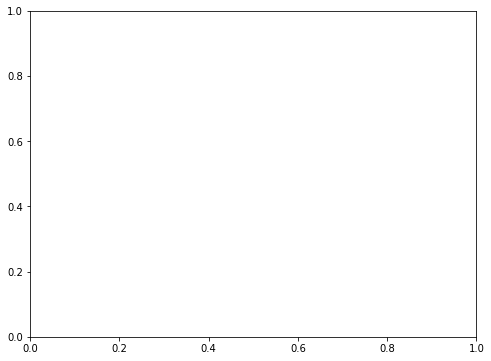

In [50]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_train, y_train, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Training Set')
plt.show()

### Performance on test set

In [51]:
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

NameError: name 'clf' is not defined

In [52]:
print('test Acc:', accuracy_score(y_test, y_test_pred))
print('test F1:', f1_score(y_test, y_test_pred))
print('test ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))

NameError: name 'accuracy_score' is not defined

NameError: name 'plot_confusion_matrix' is not defined

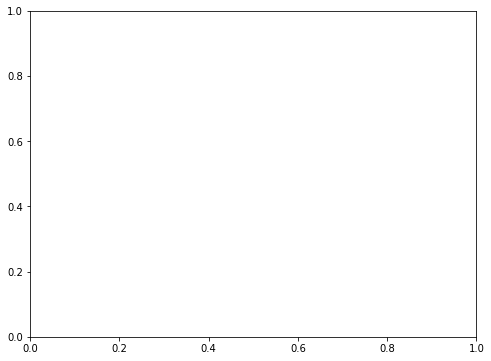

In [53]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Test Set')
plt.show()

NameError: name 'plot_roc_curve' is not defined

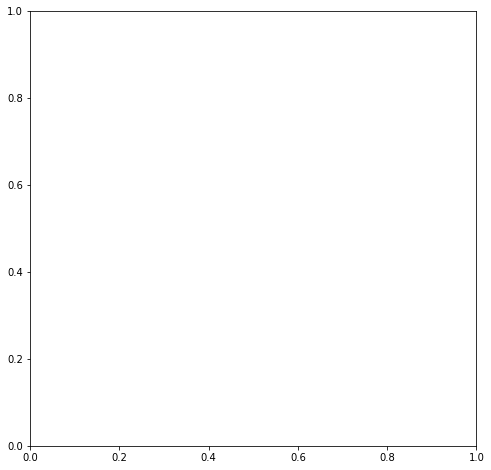

In [54]:
# ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('ROC Curve on the Test Set')
plt.show()

<a name='feature_importance'></a>
## 7. Feature Importance

The top 5 features that have the most prediction powers are:
- Average Transaction Balance
- Average Transaction Amount
- Loan Amount
- Average Salary
- Day between account creation and loan application  

They can be further studies if time permitted.

In [55]:
feature_names = num_cols.tolist() + col_trans.transformers_[1][1].get_feature_names().tolist()[:-1]
df_importance = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
df_importance.sort_values('importance', ascending=False)

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

<a name='future'></a>
## 8. Future Directions

1. **Extract more features**: Due to time limit, it is not possible to conduct a thorough study and have a deep understanding of the dataset. There are still many features in the dataset that are unused.
2. **Try other models**: Only the Random Forest model is used, but there are many good ones out there, such as Logistic Regression, XGBoost, SVM, or even neural networks.
3. **Deal with the unbalanced data**: It is important to notice this fact that the default loans are only about 10% of the total loans, so during the training process, the model will favor predicting more negatives than positive results. In order to solve this problem, we can collect more data or use resampling techniques.